In [1]:
#numpy
import numpy as np
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#plotting
from matplotlib import pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
#for performance timing
import time
#ranodm
import random

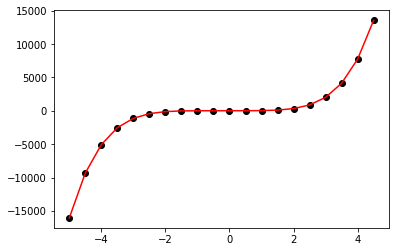

In [2]:
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10)

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')
plt.plot(Xi,yi, color="red")

In [3]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)
    self.fc2 = nn.Linear(middle,middle)
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

In [4]:
#@title Define Hyperparameters Class
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

  def __str__(self):
    out = ""
    for d in self.__dict__:
      ds = self.__dict__[d]
      out += f"{d} = {ds}   "
    return out

  def next(self):
    dict = {}
    for d in self.__dict__:
      dict[d] = next(self.__dict__[d])
    return Hyperparameters(**dict)

def sampler(func, min, max):
  while True:
    yield func(min,max)

def static(val):
  while True:
    yield val

In [5]:
#@title Instantiate Hyperparameters
hp = Hyperparameters(
  epochs = static(200),
  middle_layer = sampler(random.randint, 8, 64),
  learning_rate = sampler(random.uniform,3.5e-01,3.5e-03),
  batch_size = static(16)
)

#sample
print(hp.next())

epochs = 200   middle_layer = 38   learning_rate = 0.18667246169798982   batch_size = 16   


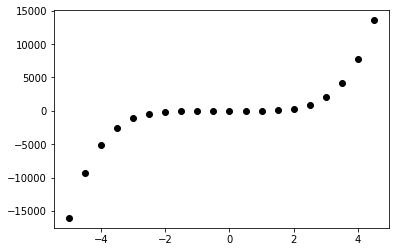

In [6]:
def sample_train_function(hp):
  hp = hp.next()

  X = np.reshape(
      np.arange(
          data_min,
          data_max,
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]
  y = y.reshape(-1, 1)
  plt.plot(X, y, 'o', color='black')

sample_train_function(hp)

177.86526489257812


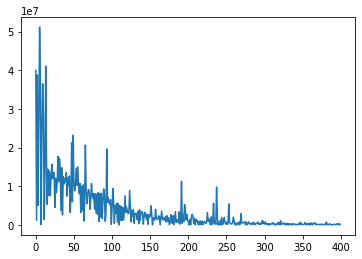

In [7]:
loss_fn = nn.MSELoss()
#@title The Main Training Function
def train_function(hp):
  hp = hp.next()

  X = np.reshape(
      np.arange(
          data_min,
          data_max,
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]

  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)

  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)

  history=[]
  start = time.time()
  for i in range(hp.epochs):
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X))
      y_batch = Variable(torch.Tensor(y))
      # forward pass
      y_pred = model(x_batch)
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)
      ll = loss.data
      history.append(ll)
      # reset gradients
      optimizer.zero_grad()
      # backwards pass
      loss.backward()
      # step the optimizer - update the weights
      optimizer.step()
  end = time.time() - start
  return end, history, model, hp

best = float("inf")
span, history, model, hp_out = train_function(hp)
plt.plot(history)
print(min(history).item())

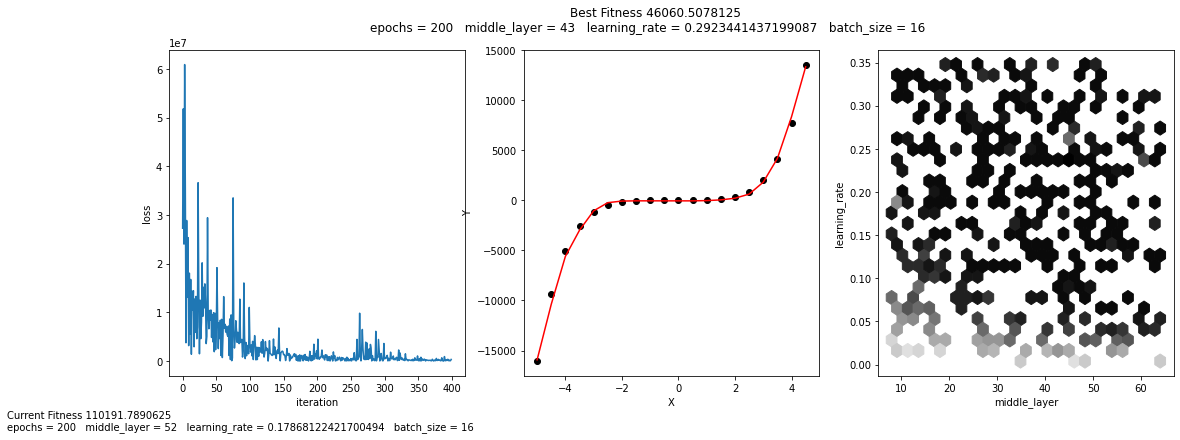

KeyboardInterrupt: 

In [8]:
#@title Run the HPO Automation
runs = 10000
best = float("inf")
best_hp = None
run_history = []
for i in range(runs):
  span, history, model, hp_out = train_function(hp)
  y_ = model(torch.Tensor(Xi))
  fitness = loss_fn(y_, torch.Tensor(yi)).data.item()
  run_history.append([fitness,*hp_out.__dict__.values()])
  if fitness < best:
    best = fitness
    best_hp = hp_out
  clear_output()

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
  fig.suptitle(f"Best Fitness {best}\n{best_hp} ")
  fig.text(0,0,f"Current Fitness {fitness} \n{hp_out}")
  ax1.plot(history)
  ax1.set_xlabel("iteration")
  ax1.set_ylabel("loss")

  ax2.plot(Xi, yi, 'o', color='black')
  ax2.plot(Xi,y_.detach().numpy(), 'r')
  ax2.set_xlabel("X")
  ax2.set_ylabel("Y")

  rh = np.array(run_history)
  hexbins = ax3.hexbin(rh[:, 2], rh[:, 3], C=rh[:, 0],
                        bins=25, gridsize=25, cmap=cm.get_cmap('gray'))
  ax3.set_xlabel("middle_layer")
  ax3.set_ylabel("learning_rate")

  plt.show()
  time.sleep(1)